# Code Summary

**Authors**: Sarah Reynolds and Kamal Acharya

**Project**: The Use of Reinforcement Learning in Realistic Emergency Scenarios

**Code Description**: 

This code creates an environment that mimics an airplane and the airports in Florida. One airport is in a 'disaster' state. A Reinforcement Learning model that uses Q-Tables is developed in this code to train the airplane to land at a safe airport as closely as possible.

At the end of this file, a demonstration of the output and multiple graphs are created for the interpretation of results.

The initial environment was generated with inspiration and from [1] and adapted to fit our project's needs, while further information about reinforcement learning and the generation of graphs was aided by [2].

**Resources**:

[1] sentdex, "Q-Learning In Our Own Custom Environment - Reinforcement Learning w/ Python Tutorial p.4," PythonProgramming.net, [Online]. Available: https://pythonprogramming.net/own-environment-q-learning-reinforcement-learning-python-tutorial/. [Accessed March 2023].

[2] A. Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, O'Reilly Media, Inc., 2019. 

Importing the required modules

In [ ]:
import numpy as np
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import math
from google.colab.patches import cv2_imshow

Setting the values for required parameters

In [ ]:
#set up the plot and the qTable
style.use("ggplot")
TABLE_NAME="sizeXX_episodesXX"

#can change the size of the board, RAM has issues after 30
SIZE = 30

HM_EPISODES = 25000 #the number of episodes to run
MOVE_PENALTY = 1 #the amount of points lost for each movement
DISASTER_AIRPORT_PENALTY = 500 #the penalty if the plane reaches an unsafe airport
SAFE_AIRPORT_REWARD = 50 #the reward for reaching a safe airport
epsilon = 0.9 #starting epsilon value
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 1000  # how often save and show results

ALL_AIRPORTS = False # If true, use all airports. If false, use a subset.
CALCULATE_CLOSEST = True # If true, calculate the closest airport and guide the plane there. If false, let the plane learn the locations of the airports.

start_q_table = None #load existing q table here if one exists

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLANE_N = 1  # plane key in dict
S_AIRPORT_N = 2  # safe_airport key in dict
D_AIRPORT_N = 3  # disaster_airport  key in dict

# the dict that determines the RGB colors shown on the display
d = {1: (0, 0, 255),
     2: (0, 255, 0),
     3: (255, 0, 0)}

Setting the values for the airports locations

In [ ]:
# Define the latitude and longitude range of the grid (defined to show the state of florida)
MAX_LAT = 31
MIN_LAT = 24
MAX_LONG = 88
MIN_LONG = 79

# Define the position of the airports [lat, long]
# Currently shows all airports in Florida
dab = [29.1847, 81.0606]
fll = [26.0725, 80.1528]
rsw = [26.5361, 81.7553]
vps = [30.4833, 86.5253]
gnv = [29.69, 82.2717]
jax = [30.4942, 81.6878]
eyw = [24.5561, 81.7594]
mlb = [28.1028, 80.6453]
mia = [25.7933, 80.2906]
mco = [28.4294, 81.3089]
ecp = [30.3583, 85.7956]
pns = [30.4733, 87.1867]
pgd = [26.9189, 81.9908]
sfb = [28.7778, 81.2375]
srq = [27.3956, 82.5544]
pie = [27.61, 82.6875]
tlh = [30.3967, 84.3503]
tpa = [27.9797, 82.5347]
pbi = [26.6831, 80.0956]

Defining class that will define the locations of the airports in our environment

In [ ]:
# Sets locations for all actors (airports and planes)
class Location:
    # initializes location to location provided or random if not provided
    def __init__(self, lat = 0, long = 0):
        if lat == 0: 
          self.x = np.random.randint(0, SIZE)
        else:
          lat_range = (MAX_LAT - MIN_LAT)/SIZE
          lat_box = 0
          position = MAX_LAT
          while position > lat and lat_box < (SIZE-1):
            position -= lat_range
            lat_box += 1
          self.x = lat_box
        if long == 0:
          self.y = np.random.randint(0, SIZE)
        else:
          long_range = (MAX_LONG - MIN_LONG)/SIZE
          long_box = 0
          position = MAX_LONG
          while position > long and long_box < (SIZE-1):
            position -= long_range
            long_box += 1
          self.y = long_box 

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    # Defines the 4 movement choices
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)


    #Defines and updates location based on movement, keeping pieces on the board
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

Initializing the q table

  - The q-table has a value for all possible moves (4) for all spots on the board

In [ ]:
if start_q_table is None:
    # initialize the q-table
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

Choosing random airport as the disaster airport and remaining as the safe airport from the availabel list of airports

In [ ]:
airports = ['DAB', 'ECP', 'PNS', 'PGD', 'PBI']

# Choose a random airport from the list to be the disaster location
random_airport = random.choice(airports)

# Create a new list with the remaining airports
remaining_airports = [airport for airport in airports if airport != random_airport]

# print("Random airport: ", random_airport)
# print("Remaining airports: ", remaining_airports)

In [ ]:
#Function to show the initial environment only for check up purpose
#Run to see the location of airports
'''
showState is a function that takes in information about the environment and displays
an image for a human audience to interpret

Parameters:
  safe_airports: a List of location objects that represent airports not under disaster
  plane: a location object that represents the current position of the airplane
  disaster_airport: the airport that has been selected as having a 'disaster' state
'''
def showState(safe_airports, plane, disaster_airport):
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            for safe_airport in safe_airports:
              env[safe_airport.x][safe_airport.y] = (0, 255, 0)  # sets the safe_airport locations tile to green color
            env[plane.x][plane.y] = (255, 0, 0)  # sets the plane tile to blue
            env[disaster_airport.x][disaster_airport.y] = (0, 0, 255)  # sets the disaster_airport location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb
            img = img.resize((300, 300))  # resizing so we can see our agent
            cv2_imshow(np.array(img))  # show it!

Allocating the location of the airport in our environment based on their actual latitude and longitude

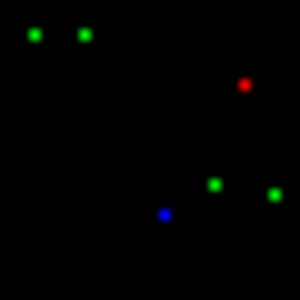

In [ ]:
# See initial view for testing
plane = Location()
DAB = Location(lat=dab[0],long=dab[1])
FLL = Location(lat=fll[0],long=fll[1])
RSW = Location(lat=rsw[0],long=rsw[1])
VPS = Location(lat=vps[0],long=vps[1])
GNV = Location(lat=gnv[0],long=gnv[1])
JAX = Location(lat=jax[0],long=jax[1])
EYW = Location(lat=eyw[0],long=eyw[1])
MLB = Location(lat=mlb[0],long=mlb[1])
MIA = Location(lat=mia[0],long=mia[1])
MCO = Location(lat=mco[0],long=mco[1])
ECP = Location(lat=ecp[0],long=ecp[1])
PNS = Location(lat=pns[0],long=pns[1])
PGD = Location(lat=pgd[0],long=pgd[1])
SFB = Location(lat=sfb[0],long=sfb[1])
SRQ = Location(lat=srq[0],long=srq[1])
PIE = Location(lat=pie[0],long=pie[1])
TLH = Location(lat=tlh[0],long=tlh[1])
TPA = Location(lat=tpa[0],long=tpa[1])
PBI = Location(lat=pbi[0],long=pbi[1])

if ALL_AIRPORTS:
  airports = [DAB, FLL, RSW, VPS, GNV, JAX, EYW, MLB, 
              MIA, MCO, ECP, PNS, PGD, SFB, SRQ, PIE, 
              TLH, TPA, PBI]
else:
  #Limit the list of airports to make sense training in such a small sphere
  airports = [DAB, ECP, PNS, PGD, PBI]

disaster_airport = random.choice(airports)
safe_airports= [airport for airport in airports if airport != random_airport]

# See an example generation of an airport
showState(safe_airports,plane,disaster_airport)

Function for calculating the nearest safest airport

In [ ]:
'''
nearestAirport takes in the location objects of a plane and a list of the safe airports.
It returns the location object of the nearest airport.
'''
def nearestAirport(plane,safe_aiports):
  min_distance = float('inf')
  nearest_airport = None
  for safe_airport in safe_airports:
      distance = math.sqrt((plane.x - safe_airport.x)**2 + (plane.y - safe_airport.y)**2)
      if distance < min_distance:
          min_distance = distance
          nearest_airport = safe_airport
  return nearest_airport

Creating episodes and training our agent

In [ ]:
episode_rewards = []
frames = []
episode_steps=[]

for episode in range(HM_EPISODES):
    plane = Location()
    disaster_airport = random.choice(airports)
    safe_airports= [airport for airport in airports if airport != random_airport]
    if episode % SHOW_EVERY == 0:
        frames.append([])
        print(f"on #{episode}, epsilon is {epsilon}")
        if episode !=0:
          print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
          print(f"{SHOW_EVERY} ep mean: {np.mean(episode_steps[-SHOW_EVERY:])}")
        show = True
    else:
        show = False


    episode_reward = 0
    # episode_step = 0

    #Find the nearest safe airport from the plane
    safe_airport=nearestAirport(plane,safe_airports)
    for i in range(200):
        if CALCULATE_CLOSEST: # use the planes relation to the closest airport and the relation to the disaster
          obs = (plane-safe_airport, plane-disaster_airport)
        else: # use the planes general location and relation to disaster
          obs = ((plane.x,plane.y), plane-disaster_airport)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        plane.action(action)

        # Check to see if a safe airport was reached
        foundAirport = False
        for safe_airport in safe_airports:
          if safe_airport.x == plane.x and safe_airport.y == plane.y:
            reward = SAFE_AIRPORT_REWARD
            foundAirport = True
            break
          
        # Check to see if the plane hit the disaster or just a normal move
        if not foundAirport:
          if plane.x == disaster_airport.x and plane.y == disaster_airport.y:
              reward = -DISASTER_AIRPORT_PENALTY
          else:
              reward = -MOVE_PENALTY
        
        if CALCULATE_CLOSEST:
          new_obs = (plane-safe_airport, plane-disaster_airport)
        else:
          new_obs = ((plane.x,plane.y), plane-disaster_airport)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == SAFE_AIRPORT_REWARD:
            new_q = SAFE_AIRPORT_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        # Log the results
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            for safe_airport in safe_airports:
              env[safe_airport.x][safe_airport.y] = d[S_AIRPORT_N]  # sets the safe_airport location to green color
            env[plane.x][plane.y] = d[PLANE_N]  # sets the plane location to blue
            env[disaster_airport.x][disaster_airport.y] = d[D_AIRPORT_N]  # sets the disaster_airport location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb
            img = img.resize((300, 300))  # resizing so we can see our agent
            frames[-1].append(img) # add to this episode's frame set for animation
            #cv2_imshow(np.array(img))  # show it!
            if reward == SAFE_AIRPORT_REWARD or reward == -DISASTER_AIRPORT_PENALTY:  # End for reaching airport may be safe or disaster
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == SAFE_AIRPORT_REWARD or reward == -DISASTER_AIRPORT_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    episode_steps.append(i)
    epsilon *= EPS_DECAY

on #0, epsilon is 0.9
on #1000, epsilon is 0.7368429387988045
1000 ep mean: -99.343
1000 ep mean: 127.464
on #2000, epsilon is 0.603263907175178
1000 ep mean: -40.366
1000 ep mean: 81.798
on #3000, epsilon is 0.49390083359356435
1000 ep mean: -4.37
1000 ep mean: 51.871
on #4000, epsilon is 0.404363713000291
1000 ep mean: 12.782
1000 ep mean: 36.096
on #5000, epsilon is 0.33105838514525754
1000 ep mean: 20.088
1000 ep mean: 29.249
on #6000, epsilon is 0.27104225936046566
1000 ep mean: 26.113
1000 ep mean: 23.53
on #7000, epsilon is 0.22190619436203765
1000 ep mean: 28.098
1000 ep mean: 21.851
on #8000, epsilon is 0.18167779154598082
1000 ep mean: 31.966
1000 ep mean: 18.034
on #9000, epsilon is 0.14874221981913022
1000 ep mean: 33.449
1000 ep mean: 16.449
on #10000, epsilon is 0.12177739374998418
1000 ep mean: 35.457
1000 ep mean: 14.543
on #11000, epsilon is 0.09970090298888634
1000 ep mean: 36.937
1000 ep mean: 13.063
on #12000, epsilon is 0.08162656262136181
1000 ep mean: 37.73
1000 

Plotting the graph for the rewards

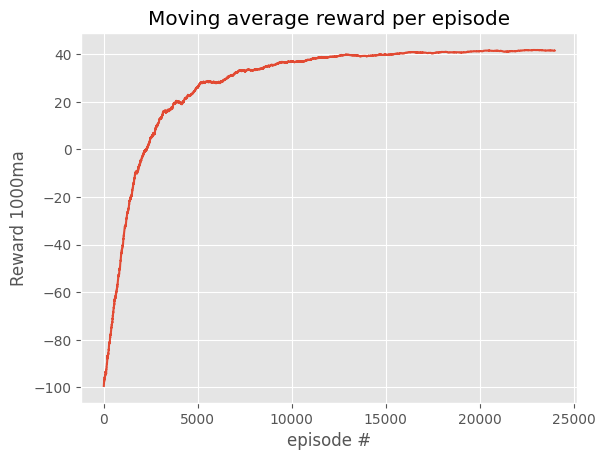

In [ ]:
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.title('Moving average reward per episode')
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

Plotting the graph for the number of steps

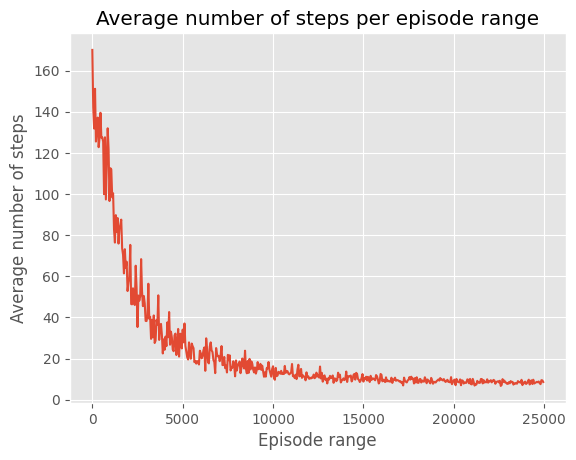

In [ ]:
x_vals = range(0, len(episode_steps), 50)
y_vals = [sum(episode_steps[i:i+50])/50 for i in range(0, len(episode_steps), 50)]
plt.plot(x_vals, y_vals)
plt.xlabel('Episode range')
plt.ylabel('Average number of steps')
plt.title('Average number of steps per episode range')
plt.show()


Get animations of model progress

In [ ]:
# From Textbook:

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
# a helper function for creating the animation
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,
    
#To view a set of images as an animation
def plot_animation(frames, name, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    video = anim.to_html5_video()

    writervideo = animation.FFMpegWriter(fps=60)
    anim.save(name+'.mp4', writer=writervideo)
    plt.close()
    return anim

In [ ]:
len(frames)

25

In [ ]:
# Plot the first animation saved
plot_animation(frames[0],"beginning")

In [ ]:
# Plot an animation from the middle of training
plot_animation(frames[int(len(frames)/2)],"middle")

In [ ]:
# Plot the final animation saved
plot_animation(frames[len(frames)-1],"end")